In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

# Étude of Ferdinand (2018): "Coevolution of Data and Hypotheses"

I saw Vanessa Ferdinand give a talk at the Cultural Evolution Society meeting this year. It was on [her EVOLANG paper](https://www.researchgate.net/publication/324479016_The_coevolution_of_data_and_hypotheses_in_bayesian_cultural_evolution) "The coevolution of data and hypotheses in bayesian cultural evolution." Ferdinand uses a formal equivalence between Bayesian hypothesis updating and the replicator equation to build a formal model of the coevolution of private beliefs (hypotheses) and public communications (observable variant population data). She says "(find quote about Sperber)." 

As this is a general model, it seems we should look for ways to cast existing models we're currently interested in into that framework. In order to do this, we need to deeply understand the model, which I don't yet. This notebook is my process of understanding her paper. After a numpy and matplotlib warmup, I will explain the Ferdinand coevolution model as she presents it, rework it into linear algebra as an educational exercise, and implement my linear algebra in NumPy. Ferdinand uses ternary plots to illustrate how the model works with three cultural variants and three hypotheses. I've been eyeing those wanting to learn them, and this seems like a good opportunity.

## NumPy and matplotlib warmup

Extremely simple example to remember how to write linear algebra in $\LaTeX$ and do matrix math in numpy.

$$
X = I = \begin{pmatrix} 1 & 0 \\
             0 & 1 \\
     \end{pmatrix}
$$

$$
y = \begin{pmatrix} \pi \\ -\pi
\end{pmatrix}
$$

$$
z = Xy = Iy = y
$$

[ 3.14159265 -3.14159265]


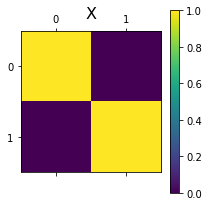

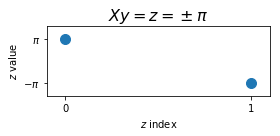

In [2]:
X = np.array([[1, 0], [0, 1]])
y = np.array([np.pi, -np.pi])

# z = X.dot(y)
# New matrix-vector notation in Python 3.5!
# See https://www.python.org/dev/peps/pep-0465
z = X @ y  

fig, ax = plt.subplots(figsize=(3,3))
mat = ax.matshow(X)
ax.set_title('X', size=16)
fig.colorbar(mat)
plt.figure(figsize=(4,2))
plt.plot(z, 'o', ms=10)
plt.xlim([-.1, 1.1])
plt.xticks([0, 1])
plt.xlabel(r'$z$ index')
plt.yticks([-np.pi, np.pi], [r'$-\pi$', r'$\pi$'])
plt.ylim([-5, 5])
plt.ylabel(r'$z$ value')
plt.title(r'$Xy = z = \pm \pi$', size=16)
print(z)

## Ferdinand (2018) model

### Individual evolution of cultural artifacts and worldview hypotheses

First, consider the replicator dynamics of cultural artifacts $d_i$,

$$
p(d_i)' = \frac{p(d_i)f(d_i)}{\sum_{k=1}^K p(d_k)f(d_k)}
$$

This equation defines the proportions of cultural artifacts, $p(d_i)$ at time $t+1$, calculated using the relative fitness of each proportion as a scaling factor

$$
\frac{f(d_i)}{Z_d}
$$

where

$$
Z_d = \sum_{k=1}^n p(d_k)f(d_k)
$$

is also calculated at every timestep. We can think of $K$ as the cultural complexity. I see no reason why the number of artifacts should equal the number of hypotheses in general, but at this point it certainly makes the math and interpretation easier.

Cultural language evolution models, (and equivalently ILMs?), such as Kalish and Griffiths (2007), consider which hypotheses are adopted by language learners given cognitive constraints (languages are differentially "difficult" and "expressive") and ambient data observed each time step, represented by $d$. Hypotheses about language evolve as follows

$$
p(h_j)' = \frac{p(h_j)p(d|h_j)}{Z_h}
$$

where 

$$
Z_h = \sum_{k=1}^K p(h_k)p(d|h_k).
$$

### Coevolution dynamics of artifacts and hypotheses


Recognizing that the fitness of a cultural artifact depends on the hypotheses entertained by individuals in the population, we write the relative fitness of an artifact with respect to hypothesis $h^*$ as

$$
f(d_i) = p(d_i | h^*)
$$


Similarly, we note that the fitness of a hypothesis is dependent on its likelihood given observed data $d^*$,

$$
f(h_j) = p(d^* | h_j)
$$

Then, the above recursions for $p(d_i)$ and $p(h_j)$ can be combined into the following coevolution equations

$$
    p(d_i)' = \sum_j \left( \frac{p(d_i)p(d_i|h_j)}{\sum_{k=1}^K p(d_k)p(d_k|h_j)} \right) p(h_j)
$$

$$
    p(h_j)' = \sum_i \left( \frac{p(h_j)p(d_i|h_j)}{\sum_{k=1}^K p(h_k)p(d_i|h_k)} \right) p(d_i).
$$

(NOT SURE HOW; DERIVE THIS)



### Matrix formulation of Ferdinand's coevolution model

Now, in order to facilitate implementation of an efficient matrix formulation in NumPy, to better understand the Ferdinand coevolution model, and just for funsies, I will cast the model in terms of matrix math. 
First, note that the likelihood of data $d_i$ given hypothesis $h_j$ is found in both coevolution equations ($p(d_i|h_j)$). Thus, we can define a likelihood matrix, $W$ with

$$
W_{ij} = p(d_i|h_j).
$$

In the simplest case, the likelihoods are constants: no matter what the frequency of $d_i$ and $h_j$, $p(d_i|h_j)$ is the same. It is conceivable, though, that this is not always the case, and this model is general enough to allow for time-varying likelihoods.

We can identify the normalization constant over artifacts and hypotheses as follows. First, for artifacts define

$$
Z_{d,j} = \sum_{k} p(d_k)p(d_k|h_j) = \sum_k W_{kj} p(d_k)
$$

or in matrix-vector form $Z_d = W^Tp(d)$.

and for hypotheses,

$$
Z_{i,h} = \sum_{k} p(h_k) p(d_i|h_k).
$$

Now the coevolution equations are

$$
p(d_i)' = p(d_i) \sum_j  \frac{W_{ij} p(h_j)}{Z_{d,j}}
$$

and

$$
p(h_j)' = p(h_j) \sum_i \frac{W_{ij} p(d_i)}{Z_{i,h}}
$$

I will define two matrices that represent the data-scaled fitness and the hypothesis-scaled fitness, used to update the artifact frequencies and the hypothesis frequencies, respectively. First, the data-scaled fitness is

$$
D_{ij} = W_{ij} / Z_{d,j} = \begin{bmatrix}
    W_{11}/Z_{d,1} & W_{12}/Z_{d,2} & \cdots & W_{1K} / Z_{d,K} \\
    \vdots         & \ddots         & \ddots & W_{2K} / Z_{d,K} \\
    \vdots         & \ddots         & \ddots & \vdots           \\
    W_{KK}/Z_{d,1} & \cdots         & \cdots & W_{KK} / Z_{d,K}
    \end{bmatrix}
$$

from which we can write 

$$
p(d_i)' = p(d_i) \sum_j D_{ij} p(h_j),
$$

which can be written in terms of the Hadamard product, $\odot$, which is just element-wise multiplication, and a matrix-vector multiplication $D p(h)$:

$$
p(d)' = \left( D p(h) \right) \odot p(d)
$$

Similarly, I define the hypothesis-scaled fitness

$$
H_{ij} = W_{ij} / Z_{i,h} = \begin{bmatrix}
    W_{11}/Z_{1,h} & W_{12}/Z_{1,h} & \cdots & W_{1K} / Z_{1,h} \\
    \vdots         & \ddots         & \ddots & W_{2K} / Z_{2,h} \\
    \vdots         & \ddots         & \ddots & \vdots           \\
    W_{KK}/Z_{K,h} & \cdots         & \cdots & W_{KK} / Z_{K,h}
    \end{bmatrix}
$$

and now we can write the vector-valued recursion as

$$
p(h)' = \left( H^T p(d) \right) \odot p(h)
$$

Now I will replicate Ferdinand's simple $K=3$ example given in Section 2 of the paper.

In [3]:
W = np.array(
    [[.8, .2, .3], 
     [.1, .6, .3], 
     [.1, .2, .4]]
)
print(W)
print(W[:,0])  # Likelihoods of data under h_1
print(W[0,:])  # Fitness of hypotheses given data d_1

[[0.8 0.2 0.3]
 [0.1 0.6 0.3]
 [0.1 0.2 0.4]]
[0.8 0.1 0.1]
[0.8 0.2 0.3]


In [4]:
A = np.array([[1, 1], [1, 1]])
b = np.array([0.5, 0.25])

div1 = np.array([b for _ in range(2)])
print(div1)
print()

div2 = np.array([b for _ in range(2)]).T
print(div2)
print()
print(A / div1)
print()
print(A / div2)

[[0.5  0.25]
 [0.5  0.25]]

[[0.5  0.5 ]
 [0.25 0.25]]

[[2. 4.]
 [2. 4.]]

[[2. 2.]
 [4. 4.]]


In [5]:
pd_init = [1/3, 1/3, 1/3]
print(pd_init)  # Regular Python division always floating point.

ph_init = pd_init.copy()  # Without copy ph_init would reference pd_init


def iterate_pd(pd_current, ph_current, W):
    Z_d = W.T @ pd_current
    divisors = np.array([Z_d for _ in range(len(pd_current))])

    D = W / divisors
    return (D @ ph_current) * pd_current

pd_next = iterate_pd(pd_init, ph_init, W)
print()
print(pd_next)
print(sum(pd_next))


def iterate_ph(pd_current, ph_current, W):
    Z_h = W @ ph_current
    divisors = np.array([Z_h for _ in range(len(ph_current))]).T

    H = W / divisors
#     print(H.T)
    return (H.T @ pd_current) * ph_current

ph_next = iterate_ph(pd_next, ph_init, W)
print()
print(ph_next)
print(sum(ph_next))

pd_next = iterate_pd(pd_next, ph_next, W)
ph_next = iterate_ph(ph_next, pd_next, W)

print()
print('p(d) =', pd_next)
print('p(h) =', ph_next)

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

[0.43333333 0.33333333 0.23333333]
1.0

[0.33333333 0.33333333 0.33333333]
1.0

p(d) = [0.50718866 0.33064099 0.16217034]
p(h) = [0.40964837 0.38574005 0.20461159]


In [6]:
# https://github.com/marcharper/python-ternary

def pd_only_simulation(ph=[1/3, 1/3, 1/3], W=None, pd_init=[1/3, 1/3, 1/3], conv_limit=1e-2):
    
    pd_series = np.array([pd_init])
    if W is None:
        W = np.array(
            [[.8, .2, .3], 
             [.1, .6, .3], 
             [.1, .2, .4]]
        )
        
    pd = pd_init
    diff = conv_limit + 1
    n_pd = 1
    
    while diff > conv_limit:
        pd_next = iterate_pd(pd, ph, W)
        diff = np.linalg.norm(pd - pd_next)
        pd = pd_next
        pd_series = np.append(pd_series, pd)
        n_pd += 1
        
    return pd_series.reshape(n_pd, 3)

[[5.61227423e-01 4.38772415e-01 1.61790077e-07]
 [5.61226670e-01 4.38773221e-01 1.09032512e-07]
 [5.61226109e-01 4.38773817e-01 7.34784665e-08]]


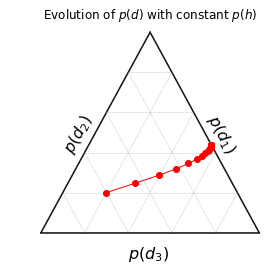

In [7]:
# Parameters according to Section 2.
pd_init = [.2, .2, .6]
ph = [.3, .4, .3]
pd_only = pd_only_simulation(pd_init=pd_init, ph=ph, conv_limit=1e-6)

print(pd_only[-3:])

fontsize=16
import ternary
fig, ax = plt.subplots(figsize=(4,4))
ax.axis('off')
figure, tax  = ternary.figure(ax, scale=1.0)
tax.boundary()
tax.gridlines(multiple=0.2, color='gray')
tax.set_title(r'Evolution of $p(d)$ with constant $p(h)$')
tax.plot(pd_only, linewidth=1, color='red', marker='o', ms=6)
# tax.ticks(axis='lbr', linewidth=1, multiple=0.2)
tax.left_axis_label(r'$p(d_2)$', fontsize=fontsize)
tax.right_axis_label(r'$p(d_1)$', fontsize=fontsize)
tax.bottom_axis_label(r'$p(d_3)$', fontsize=fontsize)
tax.show()

In [8]:
def ph_only_simulation(pd=[1/3, 1/3, 1/3], W=None, ph_init=[1/3, 1/3, 1/3], conv_limit=1e-2, max_its=1e4):
    
    ph_series = np.array([ph_init])
    if W is None:
        W = np.array(
            [[.8, .2, .3], 
             [.1, .6, .3], 
             [.1, .2, .4]]
        )
        
    ph = ph_init
    diff = conv_limit + 1
    n_ph = 1
    its = 0
    while diff > conv_limit and n_ph < max_its:
        
        ph_next = iterate_ph(pd, ph, W)
        diff = np.linalg.norm(ph - ph_next)
        ph = ph_next
        ph_series = np.append(ph_series, ph)
        n_ph += 1
        
    return ph_series.reshape(n_ph, 3)

In [9]:
def plot_ternary(series, kind='data'):
    fontsize=16
    import ternary
    fig, ax = plt.subplots(figsize=(4,4))
    ax.axis('off')
    figure, tax  = ternary.figure(ax, scale=1.0)
    tax.boundary()
    tax.gridlines(multiple=0.2, color='gray')
    
    
    # tax.ticks(axis='lbr', linewidth=1, multiple=0.2)
    if kind == 'data':
        tax.set_title(r'Evolution of $p(d)$ with constant $p(h)$')
        tax.left_axis_label(r'$p(d_2)$', fontsize=fontsize)
        tax.right_axis_label(r'$p(d_1)$', fontsize=fontsize)
        tax.bottom_axis_label(r'$p(d_3)$', fontsize=fontsize)
        
        tax.plot(series, linewidth=1, color='red', marker='o', ms=6)
        
    elif kind == 'hypotheses':
        tax.set_title(r'Evolution of $p(h)$ with constant $p(d)$')
        tax.left_axis_label(r'$p(d_2)$', fontsize=fontsize)
        tax.right_axis_label(r'$p(d_1)$', fontsize=fontsize)
        tax.bottom_axis_label(r'$p(d_3)$', fontsize=fontsize)
        
        tax.plot(series, linewidth=1, color='blue', marker='o', ms=6)
        
    elif kind == 'both':
        tax.set_title(r'Coevolution of $p(d)$ and $p(h)$')
        tax.left_axis_label(r'$p(d_2)$, $p(h_2)$', fontsize=fontsize)
        tax.right_axis_label(r'$p(d_1)$, $p(h_1)$', fontsize=fontsize)
        tax.bottom_axis_label(r'$p(d_3)$, $p(h_3)$', fontsize=fontsize)
        
        tax.plot(series[0], linewidth=1, color='red', 
                 marker='o', ms=6, label=r'$p(d)$')
        tax.plot(series[1], linewidth=1, color='blue', 
                 marker='o', ms=6, label=r'$p(h)$')
        ax.legend(fontsize=14)
    else:
        raise NotImplemented(kind + ' not a known kind for ternary plot')
    
    tax.show()

In [10]:
pd = [.2, .2, .6]
ph_init = [.3, .4, .3]
ph_only = ph_only_simulation(ph_init=ph_init, pd=pd, conv_limit=1e-4)

[[4.95719082e-06 4.30634859e-04 9.99564408e-01]
 [3.71827257e-06 3.58824877e-04 9.99637457e-01]
 [2.78894270e-06 2.98994646e-04 9.99698216e-01]]


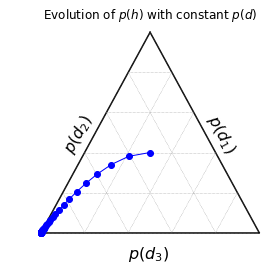

In [11]:
print(ph_only[-3:])
plot_ternary(ph_only, kind='hypotheses')

In [12]:
def coevolution_simulation(
        pd_init=[1/3, 1/3, 1/3], 
        W=None, 
        ph_init=[1/3, 1/3, 1/3],
        conv_limit=1e-2, 
        max_its=1e4):
    
    pd_series = np.array([pd_init])
    ph_series = np.array([ph_init])
    
    if W is None:
        W = np.array(
            [[.8, .2, .3], 
             [.1, .6, .3], 
             [.1, .2, .4]]
        )
        
    ph = ph_init
    pd = pd_init
    diff = conv_limit + 1

    n = 1
    
    while diff > conv_limit and n < max_its:
        
        pd_next = iterate_pd(pd, ph, W)
        ph_next = iterate_ph(pd_next, ph, W)
        diff = np.linalg.norm(pd - pd_next) + np.linalg.norm(ph - ph_next)
        
        pd = pd_next
        ph = ph_next
        
        pd_series = np.append(pd_series, pd)
        ph_series = np.append(ph_series, ph)
        n += 1
        
    return (pd_series.reshape(n, 3), ph_series.reshape(n, 3))

In [13]:
pd_init = [.2, .2, .6]
ph_init = [.3, .4, .3]
series = coevolution_simulation(pd_init=pd_init, ph_init=ph_init)

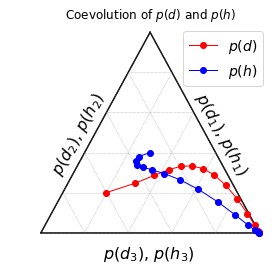

In [14]:
plot_ternary(series, kind='both')